In [5]:
from functions import *
from step1_functions import *
import pandas as pd
from time_stitches import *
from features import *
import warnings

warnings.filterwarnings('ignore')

In [19]:
delta_video_tracking = {'20': [13, 14, 15],
                        '27' : [-1.5, 0, 0],
                        '13' : [-15.5, -14, -13],
                        '10' : [5, 7, 0],
                        '16' : [40, 0, 0],
                        '19': [-3.5, -2.5, 0]}

In [2]:
np.load('subject_info_modified.npy')

array([[28,  0, 21,  0,  0,  1,  0,  1,  0,  0,  0,  0,  1,  3,  3],
       [24,  0, 21,  1,  0,  0,  1,  1,  1,  0,  0,  0,  2,  6,  5],
       [ 1,  0, 22,  1,  3,  2,  1,  3,  3,  0,  0,  0,  1, 14,  7],
       [29,  0, 22,  1,  0,  1,  0,  2,  1,  0,  1,  0,  1,  7,  6],
       [20,  0, 22,  1,  0,  1,  1,  0,  0,  0,  0,  0,  0,  3,  3],
       [14,  0, 22,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  4,  4],
       [31,  0, 22,  0,  0,  1,  0,  2,  0,  0,  0,  0,  1,  4,  3],
       [ 5,  0, 23,  1,  0,  2,  0,  2,  0,  0,  0,  0,  0,  5,  3],
       [ 2,  0, 23,  0,  0,  0,  0,  3,  2,  0,  0,  0,  1,  6,  3],
       [ 8,  0, 23,  1,  0,  0,  2,  2,  0,  0,  1,  0,  0,  6,  4],
       [26,  1, 25,  1,  0,  1,  0,  1,  0,  0,  1,  0,  0,  4,  4],
       [ 4,  1, 25,  1,  0,  1,  0,  0,  1,  0,  0,  0,  1,  4,  4],
       [ 7,  1, 26,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1],
       [13,  1, 26,  1,  0,  3,  0,  0,  1,  0,  1,  0,  0,  6,  4],
       [15,  1, 28,  0,  0,  0,  0

In [5]:
sub_manual = pd.read_csv('Annotations_final.csv', sep=';', decimal=',')
sub_manual['Start_event'] = sub_manual['Start_event'].round(3)
sub_manual['End_event'] = sub_manual['End_event'].round(3)
sub_manual = adjust_time_on_nbr_videos(sub_manual) #adjust time when there were several videos

#convert in s
sub_manual['Start_event_s'] = sub_manual['Start_event'].apply(convert_to_seconds2)
sub_manual['End_event_s'] = sub_manual['End_event'].apply(convert_to_seconds2)

sub_manual_nh = sub_manual[(sub_manual['Tool']=='NH') | (sub_manual['Tool']=='Both')]
sub_manual_tw = sub_manual[(sub_manual['Tool']=='TW') | (sub_manual['Tool']=='Both')]

In [6]:
subject = 10
i = 6
one_sub_nh = sub_manual_nh[sub_manual_nh['Subject']==subject]
one_sub_tw = sub_manual_tw[sub_manual_tw['Subject']==subject]

needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

delta = delta_video_tracking[str(subject)]
selected_nh_manual = select_points_manually2(one_sub_nh, needle_holder_rec, delta_video_tracking=delta)
selected_tw_manual = select_points_manually2(one_sub_tw, tweezers_rec, delta_video_tracking=delta)

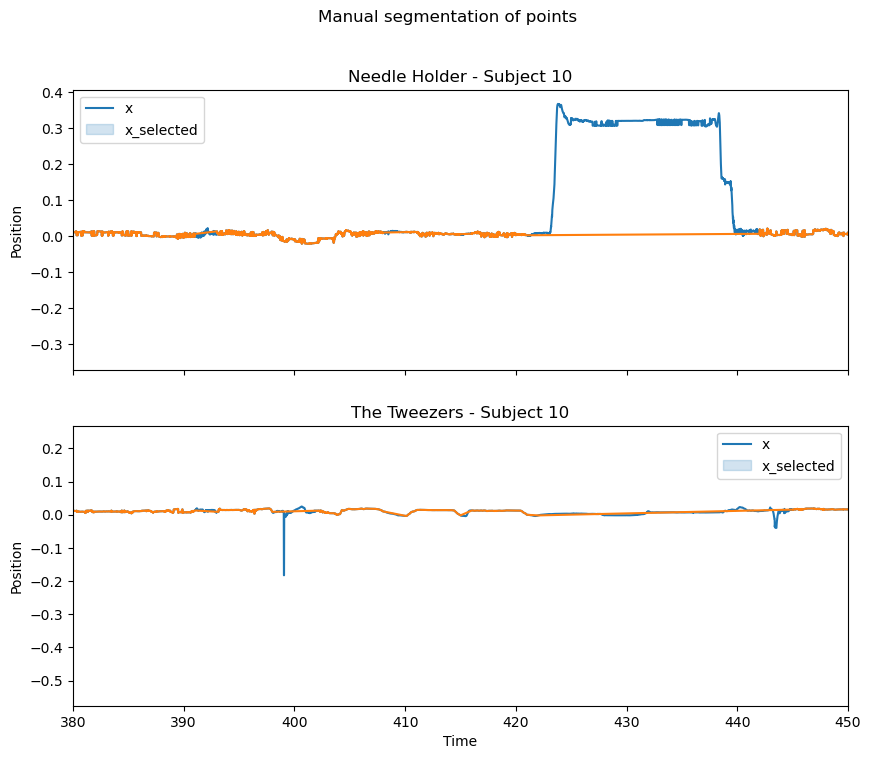

In [106]:
start_t_task = full_segments_time[i]['1'][0]
end_t_task = full_segments_time[i]['8'][1]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(x=needle_holder_rec['Time (Seconds)'], y=needle_holder_rec['X.1'], ax=ax1)
sns.lineplot(x=selected_nh_manual['Time (Seconds)'], y=selected_nh_manual['X.1'], ax=ax1)

ax1.axvline(x=start_t_task, color='black', linestyle='--')
ax1.axvline(x=end_t_task, color='black', linestyle='--')


ax1.set_xlabel('Time')
ax1.set_ylabel('Position')
ax1.set_title(f'Needle Holder - Subject {subject}')
ax1.legend(['x', 'x_selected'])
#ax1.set_ylim(-0.05, 0.05)
ax1.set_xlim(380, 450)

sns.lineplot(x=tweezers_rec['Time (Seconds)'], y=tweezers_rec['X.1'], ax=ax2)
sns.lineplot(x=selected_tw_manual['Time (Seconds)'], y=selected_tw_manual['X.1'], ax=ax2)
ax2.axvline(x=start_t_task, color='black', linestyle='--')
ax2.axvline(x=end_t_task, color='black', linestyle='--')

ax2.set_xlabel('Time')
ax2.set_ylabel('Position')
ax2.legend(['x', 'x_selected'])
ax2.set_title(f'The Tweezers - Subject {subject}')
plt.suptitle('Manual segmentation of points')
plt.show()

Extract features

In [6]:
def get_features(subject_id, derivatives_segments_tw, derivatives_segments_nh, clustering_algo= 'Manual', save =True):
    # just for the task cluster

    if save:
        directory = f"{clustering_algo}/OT_Features/S_{subject_id}/"
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
 
    NUMBER_OF_SEGMENTS = 8 

    df_metric = pd.DataFrame(columns=['Tool', 'Stitch','Effective_task_duration', 'Path_length', 'Total_rotation_x', 'Total_rotation_y', 'Total_rotation_z',
                                      'Jerk', 'EoV', 'Norm_d1_position_mean'])
    for s in range(NUMBER_OF_SEGMENTS):
        t_tw = derivatives_segments_tw[0][s][:, 0]
        t_nh = derivatives_segments_nh[0][s][:, 0]

        position_tw = derivatives_segments_tw[0][s][:, 1:4]
        position_nh = derivatives_segments_nh[0][s][:, 1:4]

        d1_position_tw = derivatives_segments_tw[1][s][:, 1:4]
        d1_position_nh = derivatives_segments_nh[1][s][:, 1:4]
    
        d2_position_tw = derivatives_segments_tw[2][s][:, 1:4]
        d2_position_nh = derivatives_segments_nh[2][s][:, 1:4]
    
        d3_position_tw = derivatives_segments_tw[3][s][:, 1:4]
        d3_position_nh = derivatives_segments_nh[3][s][:, 1:4]

        quaternion_tw = derivatives_segments_tw[0][s][:, 4:8]
        quaternion_nh = derivatives_segments_nh[0][s][:, 4:8] 
        
        euler_tw = derivatives_segments_tw[0][s][:, 8:]
        euler_nh = derivatives_segments_nh[0][s][:, 8:] 

        # path length
        path_length_tw = get_path_length(position_tw)
        path_length_nh = get_path_length(position_nh)

        # total rotation
        total_rotation_tw_x = get_total_rotation_g(euler_tw)[0]
        total_rotation_nh_x = get_total_rotation_g(euler_nh)[0]

        total_rotation_tw_y = get_total_rotation_g(euler_tw)[1]
        total_rotation_nh_y = get_total_rotation_g(euler_nh)[1]
       
        total_rotation_tw_z = get_total_rotation_g(euler_tw)[2]
        total_rotation_nh_z = get_total_rotation_g(euler_nh)[2]    

        # economy of volume
        EoV_tw = get_economy_of_volume_g(position_tw, path_length_tw)
        EoV_nh = get_economy_of_volume_g(position_nh, path_length_nh)

        # jerk
        jerk_tw = get_jerk_g(t_tw, d1_position_tw, d2_position_tw, d3_position_tw)
        jerk_nh = get_jerk_g(t_tw, d1_position_nh, d2_position_nh, d3_position_nh)

        # mean and std of d1 and d2 position
        norm_d1_position_tw_mean = get_mean_std_velocity_norm_g(d1_position_tw)[0]
        norm_d1_position_nh_mean = get_mean_std_velocity_norm_g(d1_position_nh)[0]

        df_metric.loc[len(df_metric)] = ['TW', s, t_tw.shape[0] * (1.0 / 120.0), path_length_tw, total_rotation_tw_x, total_rotation_tw_y, total_rotation_tw_z,
                                         jerk_tw, EoV_tw, norm_d1_position_tw_mean]
        df_metric.loc[len(df_metric)] = ['NH', s, t_nh.shape[0] * (1.0 / 120.0),  path_length_nh, total_rotation_nh_x, total_rotation_nh_y, total_rotation_nh_z,
                                         jerk_nh, EoV_nh, norm_d1_position_nh_mean]

    if save: 
        df_metric.to_csv(f'{directory}/df_metrics.csv', index=False)
        return df_metric

    else:
        #print('Data metrics are: ') 
        #print(data_metrics)
        return df_metric


In [ ]:
def get_list_derivatives_for_segments2(data):
    list_np_segments_d1_X = [None] * 8 
    list_np_segments_d2_X = [None] * 8 
    list_np_segments_d3_X = [None] * 8 

    print(len(data))
    print(data[0].shape)

    for s in range(8):
        np_d1_X = np.empty((data[s].shape[0], data[s].shape[1]))
        np_d2_X = np.empty((data[s].shape[0], data[s].shape[1]))
        np_d3_X = np.empty((data[s].shape[0], data[s].shape[1]))

        np_d1_X[:, 0] = data[s][:, 0]
        np_d1_X[:, 1:4] = get_derivatives(data[s][:, 0], data[s][:, 1:4])[0]
        np_d1_X[:, 4:8] = data[s][:, 4:8]
        np_d1_X[:, 8:] = get_derivatives(data[s][:, 0], data[s][:, 8:])[0]

        np_d2_X[:, 0] = data[s][:, 0]
        np_d2_X[:, 1:4] = get_derivatives(data[s][:, 0], data[s][:, 1:4])[1]
        np_d2_X[:, 4:8] = data[s][:, 4:8]
        np_d2_X[:, 8:] = get_derivatives(data[s][:, 0], data[s][:, 8:])[1]

        np_d3_X[:, 0] = data[s][:, 0]
        np_d3_X[:, 1:4] = get_derivatives(data[s][:, 0], data[s][:, 1:4])[2]
        np_d3_X[:, 4:8] = data[s][:, 4:8]
        np_d3_X[:, 8:] = get_derivatives(data[s][:, 0], data[s][:, 8:])[2]

        list_np_segments_d1_X[s] = np_d1_X
        list_np_segments_d2_X[s] = np_d2_X
        list_np_segments_d3_X[s] = np_d3_X

    return list_np_segments_d1_X, list_np_segments_d2_X, list_np_segments_d3_X

In [23]:
def get_path_length_g(time, pos):

    dt = 1/120
    diff_time = np.diff(time, axis=0)
    mask_step_bigger_dt = (diff_time>dt)

    pos_selected = pos[1:][~mask_step_bigger_dt]

    # Calculate the differences in positions between consecutive samples
    differences = np.diff(pos_selected, axis=0)
    # Calculate the Euclidean distance (path length) between consecutive points
    distances = np.linalg.norm(differences, axis=1)
    # Sum up the distances to get the total path length
    total_path_length = np.sum(distances)
    return total_path_length

In [24]:
def get_path_length_gpos(pos):

    # Calculate the differences in positions between consecutive samples
    differences = np.diff(pos, axis=0)
    # Calculate the Euclidean distance (path length) between consecutive points
    distances = np.linalg.norm(differences, axis=1)
    # Sum up the distances to get the total path length
    total_path_length = np.sum(distances)
    return total_path_length

In [25]:
def compute_v_acc_jerk_old(data_one_stitch): #Attention, comme temps pas continue, on devrait peut être enlever les points qui ont une diff de tempe de plus de 1/120
    diff_t_x_y_z = np.diff(data_one_stitch, axis = 0)
    v_x_y_z = [diff_t_x_y_z[:,1]/diff_t_x_y_z[:,0], diff_t_x_y_z[:,2]/diff_t_x_y_z[:,0], diff_t_x_y_z[:,3]/diff_t_x_y_z[:,0]]
    acc_x_y_z = [v_x_y_z[:,0]/diff_t_x_y_z[:,0], v_x_y_z[:,1]/diff_t_x_y_z[:,0], v_x_y_z[:,2]/diff_t_x_y_z[:,0]]
    jerk_x_x_z = [acc_x_y_z[:,0]/diff_t_x_y_z[:,0], acc_x_y_z[:,1]/diff_t_x_y_z[:,0], acc_x_y_z[:,2]/diff_t_x_y_z[:,0]]
    return v_x_y_z, acc_x_y_z, jerk_x_x_z

In [26]:
def compute_v_acc_jerk(data_one_stitch): #data including time and position
    dt = 1/120
    diff_t_x_y_z = np.diff(data_one_stitch, axis = 0)
    mask_step_bigger_dt = (diff_t_x_y_z[:,0]>dt)
    t_x_y_z = diff_t_x_y_z[~mask_step_bigger_dt]
    v_x_y_z = [t_x_y_z[:,1]/t_x_y_z[:,0], t_x_y_z[:,2]/t_x_y_z[:,0], t_x_y_z[:,3]/t_x_y_z[:,0]]
    acc_x_y_z = [v_x_y_z[0]/t_x_y_z[:,0], v_x_y_z[1]/t_x_y_z[:,0], v_x_y_z[2]/t_x_y_z[:,0]]
    jerk_x_x_z = [acc_x_y_z[0]/t_x_y_z[:,0], acc_x_y_z[1]/t_x_y_z[:,0], acc_x_y_z[2]/t_x_y_z[:,0]]
    return v_x_y_z, acc_x_y_z, jerk_x_x_z

In [27]:
def get_mean_v(v):
    return np.mean(np.linalg.norm(v, axis=0))

In [28]:
def get_total_rotation_g2(time, data_one_stitch):
    dt = 1/120
    diff_t = np.diff(time, axis = 0)
    mask_step_bigger_dt = (diff_t>dt)
    data= data_one_stitch[1:,:][~mask_step_bigger_dt]

    angle_differences = np.diff(data, axis=0)
    total_rotations = np.sum(angle_differences, axis=0)
    return total_rotations

In [29]:
def get_features_simplified(subject_id, list_np_segmented_tw_rec, list_np_segmented_nh_rec, clustering_algo= 'Manual', save =True):
    # just for the task cluster

    if save:
        directory = f"{clustering_algo}/OT_Features/S_{subject_id}/"
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
 
    NUMBER_OF_SEGMENTS = 8 

    df_metric = pd.DataFrame(columns=['Tool', 'Stitch','Effective_task_duration', 'Path_length', 'Total_rotation_x', 'Total_rotation_y', 'Total_rotation_z',
                                      'Jerk', 'Mean_v'])
    
    for s in range (NUMBER_OF_SEGMENTS):
        t_tw = list_np_segmented_tw_rec[s][:,0]
        t_nh = list_np_segmented_nh_rec[s][:,0]

        path_length_tw = get_path_length_g(t_tw, list_np_segmented_tw_rec[s][:,1:4])
        path_length_nh = get_path_length_g(t_nh, list_np_segmented_nh_rec[s][:,1:4])

        rotation_3d_tw = get_total_rotation_g2(t_tw, list_np_segmented_tw_rec[s][:,8:])
        rotation_3d_nh = get_total_rotation_g2(t_nh, list_np_segmented_nh_rec[s][:,8:])

        v_tw, acc_tw, jerk_tw = compute_v_acc_jerk(list_np_segmented_tw_rec[s][:,0:4])
        v_nh, acc_nh, jerk_nh = compute_v_acc_jerk(list_np_segmented_nh_rec[s][:,0:4])

        jerk_approximation_tw = get_jerk(list_np_segmented_tw_rec[s][1:,0], v_tw, acc_tw, jerk_tw) #acc not usefull
        jerk_approximation_nh = get_jerk(list_np_segmented_nh_rec[s][1:,0], v_nh, acc_nh, jerk_nh) #acc not usefull

        mean_v_tw = get_mean_v(v_tw)
        mean_v_nh = get_mean_v(v_nh)
        
        df_metric.loc[len(df_metric)] = ['TW', s, t_tw.shape[0] * (1.0 / 120.0), path_length_tw, rotation_3d_tw[0], rotation_3d_tw[1], rotation_3d_tw[2],
                                         jerk_approximation_tw, mean_v_tw]
        df_metric.loc[len(df_metric)] = ['NH', s, t_nh.shape[0] * (1.0 / 120.0), path_length_nh, rotation_3d_nh[0], rotation_3d_nh[1], rotation_3d_nh[2],
                                         jerk_approximation_nh, mean_v_nh]
    
    if save: 
        df_metric.to_csv(f'{directory}/df_metrics.csv', index=False)
        return df_metric

    else:
        return df_metric

In [30]:
#Nouvel essai
sub_manual = pd.read_csv('Annotations_final.csv', sep=';', decimal=',')
sub_manual['Start_event'] = sub_manual['Start_event'].round(3)
sub_manual['End_event'] = sub_manual['End_event'].round(3)
sub_manual = adjust_time_on_nbr_videos(sub_manual) #adjust time when there were several videos

#convert in s
sub_manual['Start_event_s'] = sub_manual['Start_event'].apply(convert_to_seconds2)
sub_manual['End_event_s'] = sub_manual['End_event'].apply(convert_to_seconds2)

sub_manual_nh = sub_manual[(sub_manual['Tool']=='NH') | (sub_manual['Tool']=='Both')]
sub_manual_tw = sub_manual[(sub_manual['Tool']=='TW') | (sub_manual['Tool']=='Both')]

subject = 10
i = 6
one_sub_nh = sub_manual_nh[sub_manual_nh['Subject']==subject]
one_sub_tw = sub_manual_tw[sub_manual_tw['Subject']==subject]

needle_holder_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_NH_reconstructed.csv')
tweezers_rec = pd.read_csv(f'Data/Sync_data/S_{subject}_TW_reconstructed.csv')

delta = delta_video_tracking[str(subject)]
selected_nh_manual = select_points_manually2(one_sub_nh, needle_holder_rec, delta_video_tracking=delta)
selected_tw_manual = select_points_manually2(one_sub_tw, tweezers_rec, delta_video_tracking=delta)

dict_segment_time = full_segments_time[i]
list_np_segmented_tw_rec = pd_2_numpy_and_segment(selected_tw_manual, dict_segment_time)
list_np_segmented_nh_rec = pd_2_numpy_and_segment(selected_nh_manual, dict_segment_time)

df_metrics = get_features_simplified(10, list_np_segmented_tw_rec, list_np_segmented_nh_rec, clustering_algo= 'Manual', save =False)
df_metrics 


,Tool,Stitch,Effective_task_duration,Path_length,Total_rotation_x,Total_rotation_y,Total_rotation_z,Jerk,Mean_v
0,TW,0,72.066667,3.200790,-184.683886,42.511501,190.031117,-27.018844,0.050150
1,NH,0,71.000000,3.468808,9.955971,16.299079,13.497260,-27.627811,0.060593
2,TW,1,61.066667,3.265381,167.808747,-64.114447,-177.804749,-26.552525,0.059081
3,NH,1,71.000000,9.951431,27.161047,28.824441,53.077462,-27.701859,0.171214
4,TW,2,67.066667,4.249153,-227.867658,-256.525110,-131.750650,-26.702373,0.071582
5,NH,2,74.000000,10.659156,14.554665,12.233528,32.778177,-27.617818,0.179726
6,TW,3,36.041667,1.404387,180.393530,-41.598951,-174.649935,-24.844862,0.046004
7,NH,3,36.800000,7.657234,93.157143,0.178789,101.314143,-25.473755,0.257984
8,TW,4,79.075000,5.403814,-195.951967,-296.972947,-170.894300,-27.151625,0.076588
9,NH,4,79.400000,4.596309,20.491549,4.463399,29.602326,-27.879541,0.075291


In [74]:
def get_path_length_g2(time, pos, sampling=1):

    dt = 1/120*sampling
    diff_time = np.diff(time, axis=0)
    mask_step_bigger_dt = (diff_time>dt)

    pos_selected = pos[1:][~mask_step_bigger_dt]

    # Calculate the differences in positions between consecutive samples
    differences = np.diff(pos_selected, axis=0)
    # Calculate the Euclidean distance (path length) between consecutive points
    distances = np.linalg.norm(differences, axis=1)
    # Sum up the distances to get the total path length
    total_path_length = np.sum(distances)
    return total_path_length

In [93]:
tweezers_s = pd_2_numpy_and_segment(tweezers_rec, dict_segment_time)
path_length_pos = []
path_length_pos_subset = []
path_length_full = []
points=2 #f/3
for s in range (8):
    path_length_pos.append(get_path_length_g2(list_np_segmented_tw_rec[s][:,0], list_np_segmented_tw_rec[s][:,1:4]))
    t = list_np_segmented_tw_rec[s][:,0]
    pos_x = list_np_segmented_tw_rec[s][:,1]
    pos_y = list_np_segmented_tw_rec[s][:,2]
    pos_z = list_np_segmented_tw_rec[s][:,3]
    pos_subset = np.vstack((pos_x[::points], pos_y[::points], pos_z[::points]))
    path_length_pos_subset.append(get_path_length_g2(t[::points],pos_subset.T, sampling=points))
    path_length_full.append(get_path_length_g(tweezers_s[s][:,0],tweezers_s[s][:,1:4]))
path_length_pos, path_length_pos_subset, path_length_full

([3.2007895626037484,
  3.265381172645904,
  4.249152953268365,
  1.4043871046795573,
  5.403813825660842,
  6.412106331781281,
  0.48936008611335846,
  2.62249504501222],
 [1.8495482331959319,
  1.9597385022020082,
  2.289326303503171,
  0.7454722244670244,
  2.9486799411257003,
  3.767609129967187,
  0.34153807355668886,
  1.51840497458848],
 [14.812416745941592,
  7.292410791972727,
  9.793931985261818,
  6.410617078110253,
  13.434430339270214,
  23.49764580684618,
  1.4507453431407156,
  13.501081743977895])

In [104]:
needle_selected = needle_holder_rec[(needle_holder_rec['Time (Seconds)']>380) & (needle_holder_rec['Time (Seconds)']<385)]
get_path_length_g2(np.array(needle_selected['Time (Seconds)']), needle_selected[['X.1', 'Y.1', 'Z.1']])

0.6813266439651293

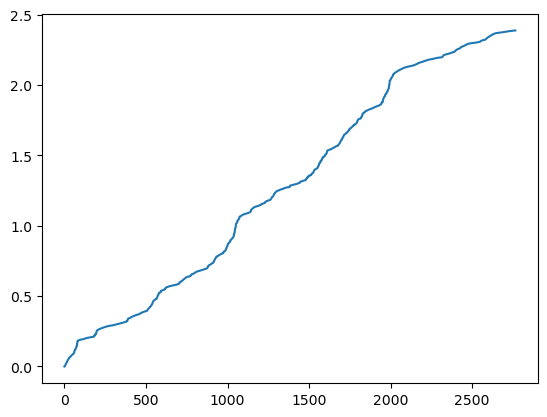

In [ ]:
cumulative = [0]
value = 0
for d in distances:
    value += d
    cumulative.append(value)
plt.plot(cumulative)